<a href="https://colab.research.google.com/github/escuccim/pytorch-face-autoencoder/blob/master/eas7_faces_7_var.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Adding some longer residual connections to try to preserve some small details which seem to be getting lost; added batch norm; replaced 6x5 convolution with global average pool followed by 1x1 convolution.

Added a discriminator and training as a GAN (but still with autoencoder) to see if that improves the results. Also switched to variational autoencoder, with slight changes to architecture to keep model from getting too big. Training from scratch.

The variational model doesn't seem to be learning much, we are going to increase the size of the hidden space and try to re-train to see if the results improve.

The model with the larger latent space doesn't seem to be learning any better. I'm going to revert to the non-variational model which did perform very well and adapt it to be variational.

In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
%matplotlib inline
import zipfile
import os

from google.colab import auth
auth.authenticate_user()

# upload checkpoint to GCS
project_id = 'mammography-198911'
bucket_name = 'pneumonia'

!gcloud config set project {project_id}

Updated property [core/project].


To take a quick anonymous survey, run:
  $ gcloud alpha survey



In [2]:
# !gsutil cp gs://{bucket_name}/gen_model_7_var_no_gan.pt ./model_7.pt
# !gsutil cp gs://{bucket_name}/gen_model_7_var1.pt ./model_7.pt
!gsutil cp gs://{bucket_name}/model_70.pt ./model_7.pt
# !gsutil cp gs://{bucket_name}/disc_model_7_var0.pt ./disc_model_7_var.pt

Copying gs://pneumonia/model_70.pt...
- [1 files][326.9 MiB/326.9 MiB]                                                
Operation completed over 1 objects/326.9 MiB.                                    


In [3]:
if not os.path.exists("celeba-dataset.zip"):
#   !kaggle datasets download -d jessicali9530/celeba-dataset
  !gsutil cp gs://{bucket_name}/celeba-dataset.zip ./celeba-dataset.zip
  zip_ref = zipfile.ZipFile('celeba-dataset.zip', 'r')
  zip_ref.extractall('data')
  zip_ref.close()

  zip_ref = zipfile.ZipFile('data/img_align_celeba.zip', 'r')
  zip_ref.extractall('data/images')
  zip_ref.close()

Copying gs://pneumonia/celeba-dataset.zip...
/ [1 files][  1.2 GiB/  1.2 GiB]   59.9 MiB/s                                   
Operation completed over 1 objects/1.2 GiB.                                      


In [4]:
if not os.path.exists("Training_Pictures.zip"):
  !wget https://s3.eu-west-3.amazonaws.com/deep.skoo.ch/Training_Pictures.zip
  zip_ref = zipfile.ZipFile('Training_Pictures.zip', 'r')
  zip_ref.extractall('data/images')
  zip_ref.close()

--2019-07-27 05:44:34--  https://s3.eu-west-3.amazonaws.com/deep.skoo.ch/Training_Pictures.zip
Resolving s3.eu-west-3.amazonaws.com (s3.eu-west-3.amazonaws.com)... 52.95.154.9
Connecting to s3.eu-west-3.amazonaws.com (s3.eu-west-3.amazonaws.com)|52.95.154.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1073596 (1.0M) [application/zip]
Saving to: ‘Training_Pictures.zip’

Training_Pictures.z 100%[===================>]   1.02M  1.49MB/s    in 0.7s    

2019-07-27 05:44:35 (1.49 MB/s) - ‘Training_Pictures.zip’ saved [1073596/1073596]



In [5]:
if not os.path.exists("imdb_images3.zip"):  
  !gsutil cp gs://{bucket_name}/imdb_images3.zip ./imdb_images3.zip
  zip_ref = zipfile.ZipFile('imdb_images3.zip', 'r')
  zip_ref.extractall('data/images')
  zip_ref.close()

if not os.path.exists("crop_part1.tar.gz"):
  !gsutil cp gs://{bucket_name}/crop_part1.tar.gz ./crop_part1.tar.gz
  !tar -xf crop_part1.tar.gz -C data/images

Copying gs://pneumonia/imdb_images3.zip...
| [1 files][  1.5 GiB/  1.5 GiB]   65.7 MiB/s                                   
Operation completed over 1 objects/1.5 GiB.                                      
Copying gs://pneumonia/crop_part1.tar.gz...
\ [1 files][ 43.3 MiB/ 43.3 MiB]                                                
Operation completed over 1 objects/43.3 MiB.                                     


In [6]:
# get test data
# if not os.path.exists("faces94.zip"):
#   !wget https://cswww.essex.ac.uk/mv/allfaces/faces94.zip
#   zip_ref = zipfile.ZipFile('faces94.zip', 'r')
#   zip_ref.extractall('data/test_images')
#   zip_ref.close()
  
# if not os.path.exists("faces96.zip"):
#   !wget https://cswww.essex.ac.uk/mv/allfaces/faces96.zip  
#   zip_ref = zipfile.ZipFile('faces96.zip', 'r')
#   zip_ref.extractall('data/test_images')
#   zip_ref.close()

if not os.path.exists("wiki_images2.zip"):
  !gsutil cp gs://{bucket_name}/wiki_images2.zip ./wiki_images.zip
  zip_ref = zipfile.ZipFile('wiki_images.zip', 'r')
  zip_ref.extractall('data/test_images')
  zip_ref.close()

if not os.path.exists("faces95.zip"):
  !wget https://cswww.essex.ac.uk/mv/allfaces/faces95.zip  
  zip_ref = zipfile.ZipFile('faces95.zip', 'r')
  zip_ref.extractall('data/test_images')
  zip_ref.close()

if not os.path.exists("GWB_200x200_JPEG.zip"):
  !wget https://s3.eu-west-3.amazonaws.com/deep.skoo.ch/GWB_200x200_JPEG.zip
  zip_ref = zipfile.ZipFile('GWB_200x200_JPEG.zip', 'r')
  zip_ref.extractall('data/test_images')
  zip_ref.close()    

Copying gs://pneumonia/wiki_images2.zip...
- [1 files][160.5 MiB/160.5 MiB]                                                
Operation completed over 1 objects/160.5 MiB.                                    
--2019-07-27 05:46:09--  https://cswww.essex.ac.uk/mv/allfaces/faces95.zip
Resolving cswww.essex.ac.uk (cswww.essex.ac.uk)... 155.245.92.179
Connecting to cswww.essex.ac.uk (cswww.essex.ac.uk)|155.245.92.179|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6425534 (6.1M) [application/zip]
Saving to: ‘faces95.zip’

faces95.zip         100%[===================>]   6.13M  5.59MB/s    in 1.1s    

2019-07-27 05:46:11 (5.59 MB/s) - ‘faces95.zip’ saved [6425534/6425534]

--2019-07-27 05:46:12--  https://s3.eu-west-3.amazonaws.com/deep.skoo.ch/GWB_200x200_JPEG.zip
Resolving s3.eu-west-3.amazonaws.com (s3.eu-west-3.amazonaws.com)... 52.95.156.5
Connecting to s3.eu-west-3.amazonaws.com (s3.eu-west-3.amazonaws.com)|52.95.156.5|:443... connected.
HTTP request sent, awai

In [0]:
BATCH_SIZE = 28
data_path = "data/images"

transform = torchvision.transforms.Compose(
    [torchvision.transforms.RandomHorizontalFlip(p=0.5), 
      torchvision.transforms.RandomApply([
        torchvision.transforms.RandomAffine(degrees=7, translate=(0.05,0.05), scale=(0.9,1.1), shear=3, resample=False, fillcolor=0),        
      ], 0.6),
      torchvision.transforms.RandomResizedCrop((192,160), scale=(0.8, 1.20)),
      torchvision.transforms.ToTensor(),
    ])

transform2 = torchvision.transforms.Compose(
    [torchvision.transforms.RandomResizedCrop((192,160), scale=(0.95, 1.05)),
      torchvision.transforms.ToTensor(),
    ])

train_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transform
    )

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=2,
    shuffle=True
)

test_dataset = torchvision.datasets.ImageFolder(
        root="data/test_images",
        transform=transform2
    )

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=32,
    num_workers=1,
    shuffle=True
)

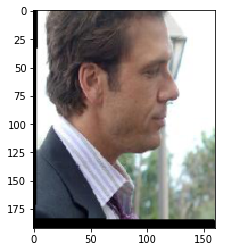

In [8]:
for (images, _) in train_loader:
  plt.imshow(images[0].permute(1,2,0))
  plt.show()
  break

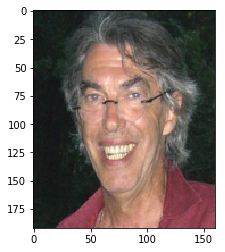

In [9]:
for (images, _) in test_loader:
  plt.imshow(images[0].permute(1,2,0))
  plt.show()
  break

In [0]:
train_dataset

Dataset ImageFolder
    Number of datapoints: 387695
    Root location: data/images

In [0]:
test_dataset

Dataset ImageFolder
    Number of datapoints: 17629
    Root location: data/test_images

In [0]:
def output_size(i, k=3, p=2, s=1, d=1):
    o = (i + 2*p - k - (k-1)*(d-1))/s + 1
    return o
  
output_size(i=64, k=3, p=1)

### Bigger Model

In [0]:
epoch_list = []

In [0]:
def vae_loss(x, x_hat, mu=None, logvar=None, d_faked=None, debug=False):
    beta_mse = 10 #32.0
    beta_kld = 0.5
    beta_gloss = 1.0 #0.5
    
    total_loss = 0
    # MSE for reconstructions
    MSE = nn.functional.mse_loss(x, x_hat)
    
    # weight the MSE loss higher so the discriminator loss doesn't overwhelm it
    if d_faked is not None:
        ones = torch.ones(d_faked.shape[0]).cuda()
        g_loss =  nn.functional.binary_cross_entropy_with_logits(d_faked, ones, reduction="mean")
    else:
        g_loss = torch.zeros(1).cuda()
    
    total_loss = (MSE * beta_mse) + (g_loss * beta_gloss)
    
    # variational loss IF we are doing variational
    if mu is not None and logvar is not None:
        KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp()) 
        total_loss += (KLD * beta_kld)
    else:
        KLD = torch.zeros(1)
        
    # print out loss info if we want to debug
    if debug:
        print("MSE Loss Raw:", MSE)
        print("MSE Loss Weighted:", MSE * beta_mse)
        print("KLD Loss Raw:", KLD)
        print("KLD Loss Weighted:", KLD * beta_kld)
        if d_faked is not None:
            print("Disc Loss Raw:", g_loss)
            print("Disc Loss Weighted:", g_loss * beta_gloss)
        print("Total Loss (weighted):", total_loss)
    
    return total_loss#, MSE * beta_mse, KLD * beta_kld, g_loss * beta_gloss
  
def disc_loss(d_true, d_faked):
    ones = torch.ones(d_true.shape[0]).cuda()
    zeros = torch.zeros(d_faked.shape[0]).cuda()
    d_loss_real = nn.functional.binary_cross_entropy_with_logits(d_true, ones, reduction="mean")
    d_loss_fake = nn.functional.binary_cross_entropy_with_logits(d_faked, zeros, reduction="mean")
    d_loss = d_loss_real + d_loss_fake

    return d_loss

def disc_loss2(labels, logits):
    d_loss = nn.functional.binary_cross_entropy_with_logits(logits, labels, reduction="mean")
    
    return d_loss    

# try to train so that we aren't using the real and fake versions of the same images for each batch 
# maybe that will improve the discriminator?
def train_discriminator(discriminator, generator, train_loader, d_optimizer, g_optimizer, train_gen=True, train_disc=True, test_loader=None, print_metrics=1000, extra_gen_train=2, plot_images=4000, num_epochs=10, display_images=5, g_scheduler=None, d_scheduler=None, d_save_path="disc_model_7.pt", g_save_path="gen_model_7_var.pt"):
    
    # if we aren't training the generator we don't need to train the discriminator less than every epoch
    if train_gen is False:
        extra_gen_train = 1
      
    try:
        for epoch in range(num_epochs):
            discriminator.train()
            generator.train()
            
            # generate unique names for the model based on the epoch so we have backups
            d_upload_path = d_save_path.split(".")[0] + str(len(epoch_list) % 2) + ".pt" 
            g_upload_path = g_save_path.split(".")[0] + str(len(epoch_list) % 2) + ".pt" 

            # initialize our metrics
            mse_loss = 0
            kld_loss = 0
            disc_losses = 0

            d_tr_loss = 0.0
            g_tr_loss = 0.0
            d_test_loss = 0.0
            g_test_loss = 0.0
            test_loss = 0.0
            test_d_loss = 0

            test_d_acc = []
            batch_losses = []
            batch_accuracies = []
            
            # loop through the data loader
            for i, (inputs, _) in enumerate(train_loader):
                if inputs.shape[0] <= 5:
                    continue
                    
                # if we are using CUDA copy the inputs to it
                if use_cuda and torch.cuda.is_available():
                    inputs = inputs.cuda()

                # zero out the gradients
                d_optimizer.zero_grad()
                g_optimizer.zero_grad()
               
                # generate our reconstructed images
                if train_gen:
                    recon, code, logvar = generator(inputs)
                else:
                    with torch.no_grad():
                        recon, code, logvar = generator(inputs)
                
                # if we are in an even iteration we only train the generator
                # so we use ones as the label
                if i % 2 == 0:
                    # copy them to the CPU to save RAM
                    disc_batch = inputs.clone().cpu()
                    
                    # feed the batch to the discriminator
                    faked_logits = discriminator(inputs)
                
                # if we are in an odd iteration we train both the discriminator
                # and the generator so we use the true labels
                else:
                    # concat the previous disc batch with the reconstructed images
                    input_shape = disc_batch.shape[0]
                    disc_batch = torch.cat((disc_batch.cuda(), recon), 0)
                    
                    # feed the batch to the discriminator
                    d_logits = discriminator(disc_batch)
                    
                    # separate the fake logits back out so we can feed them to the gen loss function
                    faked_logits = d_logits[recon.shape[0]:]
                    
                    batch_size = recon.shape[0]
                    if use_cuda:
                        ones = torch.ones(input_shape).cuda()
                        zeros = torch.zeros(batch_size).cuda()
                    else:
                        ones = torch.ones(input_shape)
                        zeros = torch.zeros(batch_size)
                    labels = torch.cat((ones, zeros))
                    
                    d_logits = discriminator(disc_batch)
                    d_loss = disc_loss2(labels, d_logits)
                    d_tr_loss += d_loss.item()
                    
                    # calculate the accuracy of our discriminator
                    d_preds = torch.sigmoid(d_logits).round()

                    d_accuracy = torch.mean((d_preds == labels).float())
                    batch_accuracies.append(d_accuracy.item())
                    
                    # update the discriminator every other step to give the generator time to catch up
                    if train_disc and (np.mean(batch_accuracies) <= 0.85 or d_accuracy.item() <= 0.75):
                        d_loss.backward(retain_graph=True)
                        d_optimizer.step()

                # update the generator, use no grad if we aren't training the generator to speed things up and save RAM
                if train_gen:
                    g_loss, mse, kld, disc_loss = vae_loss(inputs, recon, code, logvar=logvar, d_faked=faked_logits)
                    g_loss.backward()
                    g_optimizer.step()
                else:
                    with torch.no_grad():
                        g_loss, mse, kld, disc_loss = vae_loss(inputs, recon, code, logvar=logvar, d_faked=faked_logits)

                g_tr_loss += g_loss.item()
                mse_loss += mse.item()
                kld_loss += kld.item()
                disc_losses += disc_loss.item()

                batch_losses.append(g_loss.item())
            
                if i > 0 and print_metrics != 0 and i % print_metrics == 0:
                    print("\tEpoch", len(epoch_list), "batch", i, "gen total loss:", g_loss.item(), "mse loss:", mse.item(), "kld loss:", kld.item(), "xe loss:", disc_loss.item(), "disc loss:", d_loss.item(), "disc acc:", np.mean(batch_accuracies))

                if i % plot_images == 0 and i > 0:
                    fig, ax = plt.subplots(1, 2, figsize=(6,6))
                    ax[0].imshow(inputs[0].cpu().permute(1, 2, 0) )
                    ax[1].imshow(recon[0].cpu().detach().permute(1, 2, 0) )
                    plt.show()
          
            if epoch % display_images == 0:
                # plot a few random images
                try:
                    fig, ax = plt.subplots(2, 2, figsize=(6,6))
                    fig.suptitle("Training Images")
                    ax[0,0].imshow(inputs[0].cpu().permute(1, 2, 0) )
                    ax[0,1].imshow(recon[0].cpu().detach().permute(1, 2, 0) )
                    ax[1,0].imshow(inputs[1].cpu().permute(1, 2, 0) )
                    ax[1,1].imshow(recon[1].cpu().detach().permute(1, 2, 0) )
                    plt.show()
                except Exception as e:
                    print(e)

                torch.save(discriminator.state_dict(), d_save_path)
                torch.save(generator.state_dict(), g_save_path)

            if test_loader is not None:
                generator.eval()
                discriminator.eval()
                with torch.no_grad():
                    for i, (inputs, _) in enumerate(test_loader):
                        if use_cuda and torch.cuda.is_available():
                            inputs = inputs.cuda()

                        # autoencode the input images
                        recon, code, logvar = generator(inputs)

                        loss, _, _, _ = vae_loss(inputs, recon, code, logvar=logvar)
                        test_loss += loss.item()

                        # combine the real and recon images into a single batch for the discriminator
                        disc_batch = torch.cat((inputs, recon), 0)

                        # feed the batch to the discriminator
                        d_logits = discriminator(disc_batch)

                        # create labels for the disc loss function
                        batch_size = d_logits.shape[0] // 2
                        if use_cuda:
                            ones = torch.ones(batch_size).cuda()
                            zeros = torch.zeros(batch_size).cuda()
                        else:
                            ones = torch.ones(batch_size)
                            zeros = torch.zeros(batch_size)

                        labels = torch.cat((ones, zeros))

                        # run the discriminator loss function
                        d_loss = disc_loss2(labels, d_logits)
                        test_d_loss += d_loss.item()

                        # calculate the accuracy of our discriminator
                        d_preds = torch.sigmoid(d_logits).round()
                        d_accuracy = torch.mean((d_preds == labels).double())
                        test_d_acc.append(d_accuracy.item())

                try:
                    fig, ax = plt.subplots(2, 2, figsize=(6,6))
                    fig.suptitle("Test Images")
                    ax[0,0].imshow(inputs[0].cpu().permute(1, 2, 0) )
                    ax[0,1].imshow(recon[0].cpu().detach().permute(1, 2, 0) )
                    ax[1,0].imshow(inputs[1].cpu().permute(1, 2, 0) )
                    ax[1,1].imshow(recon[1].cpu().detach().permute(1, 2, 0) )
                    plt.show()
                except Exception as e:
                    print(e)
                  
            print("Epoch:", len(epoch_list), "Gen Train Loss:", g_tr_loss, "MSE Loss:", mse_loss, "KLD Loss:", kld_loss, "GAN XE Loss:", disc_losses,"Disc Train Loss:", d_tr_loss, "Test Loss:", test_loss, "Avg Tr Disc Acc:", np.mean(batch_accuracies), "Avg Te Disc Acc:", np.mean(test_d_acc))

            epoch_list.append(epoch)

            if g_scheduler is not None and epoch % 5 == 0 and epoch > 1:
                g_scheduler.step()

            if d_scheduler is not None and epoch % 5 == 0 and epoch > 1:
                d_scheduler.step()
 
    except KeyboardInterrupt:
        print("Interrupting... Saving model...")
        torch.save(generator.state_dict(), g_save_path)
        torch.save(discriminator.state_dict(), d_save_path)
        !gsutil cp {g_save_path} gs://{bucket_name}/{g_upload_path}
        !gsutil cp {d_save_path} gs://{bucket_name}/{d_upload_path}
        return 
    except ValueError:
        print("Value error occurred!")
        torch.save(generator.state_dict(), g_save_path)
        torch.save(discriminator.state_dict(), d_save_path)
        !gsutil cp {g_save_path} gs://{bucket_name}/{g_upload_path}
        !gsutil cp {d_save_path} gs://{bucket_name}/{d_upload_path}
        return 

    !gsutil cp {g_save_path} gs://{bucket_name}/{g_upload_path}
    !gsutil cp {d_save_path} gs://{bucket_name}/{d_upload_path}
 
def train_discriminator2(discriminator, generator, train_loader, d_optimizer, g_optimizer, train_gen=True, train_disc=True, test_loader=None, print_metrics=1000, extra_gen_train=2, plot_images=4000, num_epochs=10, display_images=5, g_scheduler=None, d_scheduler=None, d_save_path="disc_model_3.pt", g_save_path="gen_model_3.pt"):
    
    # if we aren't training the generator we don't need to train the discriminator less than every epoch
    if train_gen is False:
      extra_gen_train = 1
      
    try:
      for epoch in range(num_epochs):
          discriminator.train()
          generator.train()
          d_upload_path = d_save_path.split(".")[0] + str(len(epoch_list) % 2) + ".pt" 
          g_upload_path = g_save_path.split(".")[0] + str(len(epoch_list) % 2) + ".pt" 
          
          mse_loss = 0
          kld_loss = 0
          disc_losses = 0
          
          d_tr_loss = 0.0
          g_tr_loss = 0.0
          d_test_loss = 0.0
          g_test_loss = 0.0
          test_loss = 0.0
          test_d_loss = 0
          
          test_d_acc = []
          batch_losses = []
          batch_accuracies = []
          
          for i, (inputs, _) in enumerate(train_loader):
              if inputs.shape[0] == 1:
                continue
                
              if use_cuda and torch.cuda.is_available():
                  inputs = inputs.cuda()

              d_optimizer.zero_grad()
              g_optimizer.zero_grad()
              
              # generate our fake images
              if train_gen:
                  recon, code, logvar = generator(inputs)
              else:
                with torch.no_grad():
                    recon, code, logvar = generator(inputs)
              
              # concat half of the real images and half of the recons for the discriminator batch
              # it should be different halves
              batch_size = inputs.shape[0] // 2
              disc_batch = torch.cat((inputs[:batch_size], recon[batch_size:]), 0)
              
              # feed the batch to the discriminator
              d_logits = discriminator(disc_batch)
              
              if use_cuda:
                  ones = torch.ones(batch_size).cuda()
                  zeros = torch.zeros(batch_size).cuda()
              else:
                  ones = torch.ones(batch_size)
                  zeros = torch.zeros(batch_size)

              labels = torch.cat((ones, zeros))
              d_loss = disc_loss2(labels, d_logits)
              
              # calculate the accuracy of our discriminator
              d_preds = torch.sigmoid(d_logits).round()
              
              d_accuracy = torch.mean((d_preds == labels).double())
              batch_accuracies.append(d_accuracy.item())
              
              # update the discriminator every other step to give the generator time to catch up
              if train_disc and (np.mean(batch_accuracies) <= 0.80 or d_accuracy.item() <= 0.75):
                d_loss.backward(retain_graph=True)
                d_optimizer.step()
                d_optimizer.zero_grad()
              
              # feed the reconstructed images into the discriminator for the generator loss
              faked_logits = discriminator(recon)
                
              # update the generator, use no grad if we aren't training the generator to speed things up and save RAM
              if train_gen:
                g_loss, mse, kld, disc_loss = vae_loss(inputs, recon, code, logvar=logvar, d_faked=faked_logits)
                g_loss.backward()
                g_optimizer.step()
              else:
                with torch.no_grad():
                  g_loss, mse, kld, disc_loss = vae_loss(inputs, recon, code, logvar=logvar, d_faked=faked_logits)
              
              g_tr_loss += g_loss.item()
              mse_loss += mse.item()
              kld_loss += kld.item()
              disc_losses += disc_loss.item()
              
              d_tr_loss += d_loss.item()
              batch_losses.append(g_loss.item())
            
              if i > 0 and print_metrics != 0 and i % print_metrics == 0:
                print("\tEpoch", len(epoch_list), "batch", i, "gen total loss:", g_loss.item(), "mse loss:", mse.item(), "kld loss:", kld.item(), "xe loss:", disc_loss.item(), "disc loss:", d_loss.item(), "disc acc:", np.mean(batch_accuracies))

              if i % plot_images == 0 and i > 0:
                fig, ax = plt.subplots(1, 2, figsize=(6,6))
                ax[0].imshow(inputs[0].cpu().permute(1, 2, 0) )
                ax[1].imshow(recon[0].cpu().detach().permute(1, 2, 0) )
                plt.show()
          
          if epoch % display_images == 0:
              # plot a few random images
              try:
                fig, ax = plt.subplots(2, 2, figsize=(6,6))
                fig.suptitle("Training Images")
                ax[0,0].imshow(inputs[0].cpu().permute(1, 2, 0) )
                ax[0,1].imshow(recon[0].cpu().detach().permute(1, 2, 0) )
                ax[1,0].imshow(inputs[1].cpu().permute(1, 2, 0) )
                ax[1,1].imshow(recon[1].cpu().detach().permute(1, 2, 0) )
                plt.show()
              except Exception as e:
                  print(e)

              torch.save(discriminator.state_dict(), d_save_path)
              torch.save(generator.state_dict(), g_save_path)
          
          if test_loader is not None:
            generator.eval()
            discriminator.eval()
            with torch.no_grad():
              for i, (inputs, _) in enumerate(test_loader):
                if use_cuda and torch.cuda.is_available():
                  inputs = inputs.cuda()
                
                # autoencode the input images
                recon, code, logvar = generator(inputs)

                loss, _, _, _ = vae_loss(inputs, recon, code, logvar=logvar)
                test_loss += loss.item()
                
                # combine the real and recon images into a single batch for the discriminator
                disc_batch = torch.cat((inputs, recon), 0)

                # feed the batch to the discriminator
                d_logits = discriminator(disc_batch)
                
                # create labels for the disc loss function
                batch_size = d_logits.shape[0] // 2
                if use_cuda:
                    ones = torch.ones(batch_size).cuda()
                    zeros = torch.zeros(batch_size).cuda()
                else:
                    ones = torch.ones(batch_size)
                    zeros = torch.zeros(batch_size)

                labels = torch.cat((ones, zeros))
                
                # run the discriminator loss function
                d_loss = disc_loss2(labels, d_logits)
                test_d_loss += d_loss.item()
                
                # calculate the accuracy of our discriminator
                d_preds = torch.sigmoid(d_logits).round()
                d_accuracy = torch.mean((d_preds == labels).double())
                test_d_acc.append(d_accuracy.item())
                
            try:
                fig, ax = plt.subplots(2, 2, figsize=(6,6))
                fig.suptitle("Test Images")
                ax[0,0].imshow(inputs[0].cpu().permute(1, 2, 0) )
                ax[0,1].imshow(recon[0].cpu().detach().permute(1, 2, 0) )
                ax[1,0].imshow(inputs[1].cpu().permute(1, 2, 0) )
                ax[1,1].imshow(recon[1].cpu().detach().permute(1, 2, 0) )
                plt.show()
            except Exception as e:
                print(e)
                  
          print("Epoch:", len(epoch_list), "Gen Train Loss:", g_tr_loss, "MSE Loss:", mse_loss, "KLD Loss:", kld_loss, "GAN XE Loss:", disc_losses,"Disc Train Loss:", d_tr_loss, "Test Loss:", test_loss, "Avg Tr Disc Acc:", np.mean(batch_accuracies), "Avg Te Disc Acc:", np.mean(test_d_acc))
          
          epoch_list.append(epoch)
          
          if g_scheduler is not None and epoch % 5 == 0 and epoch > 1:
              g_scheduler.step()
              
          if d_scheduler is not None and epoch % 5 == 0 and epoch > 1:
              d_scheduler.step()
 
    except KeyboardInterrupt:
      print("Interrupting... Saving model...")
      torch.save(generator.state_dict(), g_save_path)
      torch.save(discriminator.state_dict(), d_save_path)
      !gsutil cp {g_save_path} gs://{bucket_name}/{g_upload_path}
      !gsutil cp {d_save_path} gs://{bucket_name}/{d_upload_path}
      return 
    except ValueError as e:
      print("Value error... Saving model...")
      print(e)
      torch.save(generator.state_dict(), g_save_path)
      torch.save(discriminator.state_dict(), d_save_path)
      !gsutil cp {g_save_path} gs://{bucket_name}/{g_upload_path}
      !gsutil cp {d_save_path} gs://{bucket_name}/{d_upload_path}
      return 
    
    !gsutil cp {g_save_path} gs://{bucket_name}/{g_upload_path}
    !gsutil cp {d_save_path} gs://{bucket_name}/{d_upload_path}
      
def train(model, train_loader, optimizer, test_loader=None, print_metrics=1000, plot_images=4000, num_epochs=10, display_images=5, scheduler=None, save_path="model_7.pt"):
    try:
      for epoch in range(num_epochs):
          model.train()
          upload_path = save_path.split(".")[0] + str(len(epoch_list) % 2) + ".pt" 
          
          tr_loss = 0.0
          test_loss = 0
          batch_losses = []
          for i, (inputs, _) in enumerate(train_loader):
              if use_cuda and torch.cuda.is_available():
                  inputs = inputs.cuda()

              optimizer.zero_grad()

              recon, code, logvar = model(inputs)
              if model.variational:
                  loss = vae_loss(inputs, recon, code, logvar=logvar)
              else:  
                  loss = vae_loss(inputs, recon, code, logvar=None)

              loss.backward()
              optimizer.step()

              tr_loss += loss.item()
              batch_losses.append(loss.item())
            
              if i > 0 and print_metrics != 0 and i % print_metrics == 0:
                print("\tEpoch", len(epoch_list), "batch", i, "loss:", loss.item())

              if i % plot_images == 0 and i > 0:
                fig, ax = plt.subplots(1, 2, figsize=(6,6))
                ax[0].imshow(inputs[0].cpu().permute(1, 2, 0) )
                ax[1].imshow(recon[0].cpu().detach().permute(1, 2, 0) )
                plt.show()
          
          if epoch % display_images == 0:
              # plot a few random images
              try:
                fig, ax = plt.subplots(2, 2, figsize=(6,6))
                fig.suptitle("Training Images")
                ax[0,0].imshow(inputs[0].cpu().permute(1, 2, 0) )
                ax[0,1].imshow(recon[0].cpu().detach().permute(1, 2, 0) )
                ax[1,0].imshow(inputs[1].cpu().permute(1, 2, 0) )
                ax[1,1].imshow(recon[1].cpu().detach().permute(1, 2, 0) )
                plt.show()
              except Exception as e:
                  print(e)

              torch.save(model.state_dict(), save_path)
#               !gsutil cp ./model.pt gs://{bucket_name}/
          
          if test_loader is not None:
            model.eval()
            with torch.no_grad():
              for i, (inputs, _) in enumerate(test_loader):
                if use_cuda and torch.cuda.is_available():
                    inputs = inputs.cuda()

                recon, code, logvar = model(inputs)

                if model.variational:
                    loss = vae_loss(inputs, recon, code, logvar=logvar)
                else:  
                    loss = vae_loss(inputs, recon, code, logvar=None)

                test_loss += loss.item()

            try:
                fig, ax = plt.subplots(2, 2, figsize=(6,6))
                fig.suptitle("Test Images")
                ax[0,0].imshow(inputs[0].cpu().permute(1, 2, 0) )
                ax[0,1].imshow(recon[0].cpu().detach().permute(1, 2, 0) )
                ax[1,0].imshow(inputs[1].cpu().permute(1, 2, 0) )
                ax[1,1].imshow(recon[1].cpu().detach().permute(1, 2, 0) )
                plt.show()
            except Exception as e:
                print(e)
                  
          print("Epoch:", len(epoch_list), "Train Loss:", tr_loss, "Test Loss:", test_loss)
          
          epoch_list.append(epoch)
          
          if scheduler is not None and epoch % 5 == 0 and epoch > 1:
              scheduler.step()

                
    except KeyboardInterrupt:
        print("Interrupting... Saving model...")
        torch.save(model.state_dict(), save_path)
        !gsutil cp {save_path} gs://{bucket_name}/{upload_path}
        return 
    
    !gsutil cp {save_path} gs://{bucket_name}/{upload_path}

def count_params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params               

In [0]:
from torch import nn
class Encoder(nn.Module):
    def __init__(self, latent_dim, variational=False):
        super(Encoder, self).__init__()
        # block 1
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)        
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.downsize1 = nn.Conv2d(96, 32, 1)
        self.bn_ds1 = nn.BatchNorm2d(32)
        
        # block 2
        self.conv4 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(64)
        self.conv6 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn6 = nn.BatchNorm2d(64)
        self.downsize2 = nn.Conv2d(192, 64, 1)
        self.bn_ds2 = nn.BatchNorm2d(64)
        
        # block 3
        self.conv7 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn7 = nn.BatchNorm2d(128)
        self.conv8 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn8 = nn.BatchNorm2d(128)
        self.conv9 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn9 = nn.BatchNorm2d(128)
        self.downsize3 = nn.Conv2d(384, 128, 1)
        self.bn_ds3 = nn.BatchNorm2d(128)
        
        # block 4
        self.conv10 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn10 = nn.BatchNorm2d(256)
        self.conv11 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn11 = nn.BatchNorm2d(256)
        self.downsize4 = nn.Conv2d(512, 256, 1)
        self.bn_ds4 = nn.BatchNorm2d(256)
        
        # block 5
        self.conv12 = nn.Conv2d(256, 384, 3, padding=1)
        self.bn12 = nn.BatchNorm2d(384)
        self.conv13 = nn.Conv2d(384, 384, 3, padding=1)
        self.bn13 = nn.BatchNorm2d(384)
        self.downsize5 = nn.Conv2d(768, 384, 1)
        self.bn_ds5 = nn.BatchNorm2d(384)
        
        # second path - skip from block 2 on
        self.conv14 = nn.Conv2d(64, 128, 3, padding=1, stride=2)
        self.bn14 = nn.BatchNorm2d(128)
        self.conv15 = nn.Conv2d(128, 128, 3, padding=1, stride=2)
        self.bn15 = nn.BatchNorm2d(128)
        
        self.fc1 = nn.Conv2d(512, latent_dim, 2) # code layer
        
        self.variational = variational
        if variational:
            self.fc2 = nn.Conv2d(512, latent_dim, 2) # variance layer
        
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(2,2)
        self.gap = nn.AdaptiveMaxPool2d(2)
        
        
    def encode(self, x):
        # input 192x160x3 - output 96x80x32
        h1 = self.relu(self.bn1(self.conv1(x)))
        h2 = self.relu(self.bn2(self.conv2(h1)))
        h3 = self.relu(self.bn3(self.conv3(h2)))
        ds1 = self.relu(self.bn_ds1(self.downsize1(torch.cat((h1,h2,h3), 1))))
        mp1 = self.max_pool(ds1)
        
        # input 89x89x32 - output 64x48x40
        h4 = self.relu(self.bn4(self.conv4(mp1)))
        h5 = self.relu(self.bn5(self.conv5(h4)))
        h6 = self.relu(self.bn6(self.conv6(h5)))
        ds2 = self.relu(self.bn_ds2(self.downsize2(torch.cat((h4,h5,h6), 1))))
        mp2 = self.max_pool(ds2)
        
        # input 54x44x64 - output 128x24x20
        h7 = self.relu(self.bn7(self.conv7(mp2)))
        h8 = self.relu(self.bn8(self.conv8(h7)))
        h9 = self.relu(self.bn9(self.conv9(h8)))
        ds3 = self.relu(self.bn_ds3(self.downsize3(torch.cat((h7,h8,h9), 1))))
        mp3 = self.max_pool(ds3)
        
        # input 128x22x22 - output 256x12x10
        h10 = self.relu(self.bn10(self.conv10(mp3)))
        h11 = self.relu(self.bn11(self.conv11(h10)))
        ds4 = self.relu(self.bn_ds4(self.downsize4(torch.cat((h10,h11), 1))))
        mp4 = self.max_pool(ds4)
        
        # input 256x11x11 - output 384x6x5
        h12 = self.relu(self.bn12(self.conv12(mp4)))
        h13 = self.relu(self.bn13(self.conv13(h12)))
        ds5 = self.relu(self.bn_ds5(self.downsize5(torch.cat((h12,h13), 1))))
        mp5 = self.max_pool(ds5)
        
        # second path - input 64x48x40
        # output 64x12x10
        h14 = self.relu(self.bn14(self.conv14(mp2)))
        h15 = self.relu(self.bn15(self.conv15(h14)))
        # output 64x6x5
        mp6 = self.max_pool(h15)
        
        # concat the paths
        concat = self.gap(torch.cat((mp5, mp6), 1))
        
        # input 4x4x64 - output latent_dimx1
        code = self.fc1(concat)
        
        if self.variational:
            logvar = self.fc2(concat)
        else:
            logvar = None
  
        return code, logvar
  
    def forward(self, x):
        code, logvar = self.encode(x)
        return code, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.ConvTranspose2d(latent_dim, 512, (6,5), stride=1)
        self.bn0 = nn.BatchNorm2d(512)
        self.deconv1 = nn.ConvTranspose2d(512, 384, 2, stride=2, output_padding=0)
        self.bn1 = nn.BatchNorm2d(384)
        self.deconv3 = nn.ConvTranspose2d(384, 256, 2, stride=2, output_padding=0)
        self.bn3 = nn.BatchNorm2d(256)
        self.deconv4 = nn.ConvTranspose2d(256, 224, 2, stride=2, output_padding=0)
        self.bn4 = nn.BatchNorm2d(224)
        self.deconv5 = nn.ConvTranspose2d(224, 192, 2, stride=2, output_padding=0)
        self.bn5 = nn.BatchNorm2d(192)
        self.deconv6 = nn.ConvTranspose2d(192, 128, 2, stride=2, output_padding=0)
        self.bn6 = nn.BatchNorm2d(128)
        self.deconv8 = nn.Conv2d(128, 3, 1, stride=1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
  
    def decode(self, x):
        # input latent_dimx1 - output 2048x1
        h0 = self.relu(self.bn0(self.fc1(x)))
        
        # in 5x5 - out 10x10
        h1 = self.relu(self.bn1(self.deconv1(h0)))
        
        # in 10x10 - out 20x20
        h3 = self.relu(self.bn3(self.deconv3(h1)))
        h4 = self.relu(self.bn4(self.deconv4(h3)))
        h5 = self.relu(self.bn5(self.deconv5(h4)))
        h6 = self.relu(self.bn6(self.deconv6(h5)))
        h8 = self.deconv8(h6)
      
        return self.sigmoid(h8)
    
    def forward(self, x):
        return self.decode(x)
    
# a model that uses the Encoder and Decoder
class SingleModel(nn.Module):
    def __init__(self, encoder, decoder, variational=False):
        super(SingleModel, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.variational = variational

    def sample(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.autograd.Variable(std.data.new(std.size()).normal_())
        return eps.mul(std).add_(mu)

    def forward(self, X):
        mu, logvar = encoder(X)

        if self.training and logvar is not None:
            z = self.sample(mu, logvar)
        else:
            z = mu
            
        recon = self.decoder(z)
        
        return recon, mu, logvar
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # block 1
        self.conv1 = nn.Conv2d(3, 48, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(48)
        self.conv2 = nn.Conv2d(48, 48, 3, padding=1)        
        self.bn2 = nn.BatchNorm2d(48)
        self.conv3 = nn.Conv2d(48, 48, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(48)
        
        # block 2
        self.conv4 = nn.Conv2d(48, 96, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(96)
        self.conv5 = nn.Conv2d(96, 96, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(96)
        self.conv6 = nn.Conv2d(96, 96, 3, padding=1)
        self.bn6 = nn.BatchNorm2d(96)
        
        # block 3
        self.conv7 = nn.Conv2d(96, 192, 3, padding=1)
        self.bn7 = nn.BatchNorm2d(192)
        self.conv8 = nn.Conv2d(192, 192, 3, padding=1)
        self.bn8 = nn.BatchNorm2d(192)
        self.conv9 = nn.Conv2d(192, 192, 3, padding=1)
        self.bn9 = nn.BatchNorm2d(192)
        
        # block 4
        self.conv10 = nn.Conv2d(192, 384, 3, padding=1)
        self.bn10 = nn.BatchNorm2d(384)
        self.conv11 = nn.Conv2d(384, 384, 3, padding=1)
        self.bn11 = nn.BatchNorm2d(384)
        
        # block 5
        self.conv12 = nn.Conv2d(384, 512, 3, padding=1)
        self.bn12 = nn.BatchNorm2d(512)
        self.conv13 = nn.Conv2d(512, 1024, 3, padding=1)
        self.bn13 = nn.BatchNorm2d(1024)
        
        self.fc1 = nn.Conv2d(1024, 2048, 1) # code layer
        self.bn14 = nn.BatchNorm2d(2048)
        self.fc2 = nn.Conv2d(2048, 1, 1)
        
        self.relu = nn.ReLU()
        self.max_pool = nn.MaxPool2d(2,2)
        self.gap = nn.AdaptiveMaxPool2d(1)
        
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.50)
        
    def discriminate(self, x):
        # input 192x160x3 - output 96x80x32
        h1 = self.relu(self.bn1(self.conv1(x)))
        h2 = self.relu(self.bn2(self.conv2(h1)))
        h3 = self.relu(self.bn3(self.conv3(h2)))
        mp1 = self.max_pool(h3)
        
        # input 89x89x32 - output 64x48x40
        h4 = self.relu(self.bn4(self.conv4(mp1)))
        h5 = self.relu(self.bn5(self.conv5(h4)))
        h6 = self.relu(self.bn6(self.conv6(h5)))
        mp2 = self.max_pool(h6)
        
        # input 54x44x64 - output 128x24x20
        h7 = self.relu(self.bn7(self.conv7(mp2)))
        h8 = self.relu(self.bn8(self.conv8(h7)))
        h9 = self.relu(self.bn9(self.conv9(h8)))
        mp3 = self.max_pool(h9)
        
        # input 128x22x22 - output 256x12x10
        h10 = self.relu(self.bn10(self.conv10(mp3)))
        h11 = self.relu(self.bn11(self.conv11(h10)))
        mp4 = self.max_pool(h11)
        
        # input 256x11x11 - output 384x6x5
        h12 = self.relu(self.bn12(self.conv12(mp4)))
        h13 = self.relu(self.bn13(self.conv13(h12)))
        mp5 = self.max_pool(h13)
        gap = self.dropout1(self.gap(mp5))
        
        # input 4x4x64 - output latent_dimx1
        fc1 = self.dropout2(self.relu(self.bn14(self.fc1(gap))))
        logits = self.fc2(fc1)
        
        return torch.squeeze(logits)
  
    def forward(self, x):
        return self.discriminate(x)

In [11]:
from torch import optim
import numpy as np

  ## YOUR CODE HERE ##
encoder = Encoder(4096, variational=True)
decoder = Decoder(4096)
# discriminator = Discriminator()
generator = SingleModel(encoder, decoder, variational = True)
params = generator.parameters()

print("Autoencoder Params:", count_params(generator))
# print("Discriminator Params:", count_params(discriminator))

# run on GPU
use_cuda = True

if use_cuda and torch.cuda.is_available():
    generator.cuda()
#     discriminator.cuda()

g_optimizer = optim.Adam(params, lr=0.00035)
# d_optimizer = optim.Adam(discriminator.parameters(), lr=0.00005)
g_scheduler = optim.lr_scheduler.ExponentialLR(g_optimizer, gamma=0.95)
# d_scheduler = optim.lr_scheduler.ExponentialLR(d_optimizer, gamma=0.95)

try:
    generator.load_state_dict(torch.load("model_7.pt"), strict = False)
    print("Autoencoder loaded")
except:
    print("Error loading autoencoder")

# try:
#     discriminator.load_state_dict(torch.load("disc_model_7_var.pt"))
#     print("Discriminator loaded")
# except:
#     print("Error loading discriminator")

Autoencoder Params: 85682371
Autoencoder loaded


In [0]:
## LOAD THE PRE-TRAINED MODEL
## WE CAN OMIT THE LAYERS THAT NEED TO BE RE-TRAINED OR WE CAN JUST KEEP THE WHOLE THING?
# pretrained_dict = torch.load("gen_model_6.pt")

# model_dict = generator.state_dict()
# pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}

# 
# pretrained_dict.pop("encoder.fc1.weight")
# pretrained_dict.pop("encoder.fc1.bias")

# # 2. overwrite entries in the existing state dict
# model_dict.update(pretrained_dict) 
# # 3. load the new state dict
# generator.load_state_dict(model_dict, strict = False)

	Epoch 0 batch 500 loss: 0.6430326700210571
	Epoch 0 batch 1000 loss: 0.5182997584342957
	Epoch 0 batch 1500 loss: 0.4867703914642334
	Epoch 0 batch 2000 loss: 0.42437541484832764


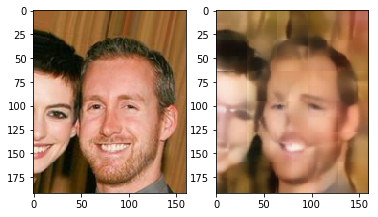

	Epoch 0 batch 2500 loss: 0.38761165738105774
	Epoch 0 batch 3000 loss: 0.3726915717124939
	Epoch 0 batch 3500 loss: 0.3602333068847656
	Epoch 0 batch 4000 loss: 0.36547955870628357


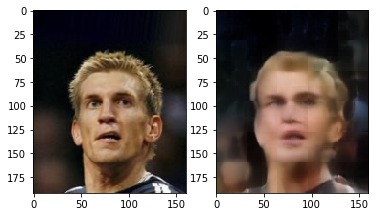

	Epoch 0 batch 4500 loss: 0.3729860782623291
	Epoch 0 batch 5000 loss: 0.3261168599128723


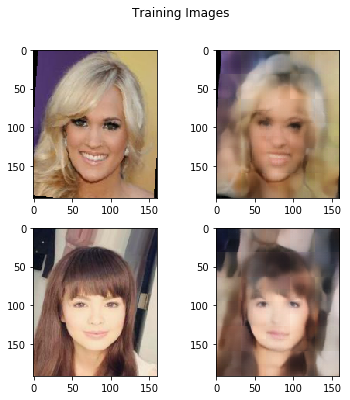

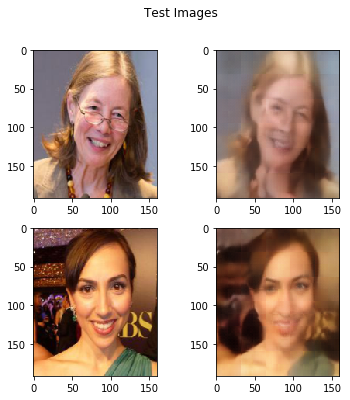

Epoch: 0 Train Loss: 2319.573708176613 Test Loss: 179.4450161755085
Copying file://gen_model_7_var.pt [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

|
Operation completed over 1 objects/326.9 MiB.                                    


In [0]:
# re-train encoder and decoder FC layers for 1 epochs
train(generator, train_loader, g_optimizer, test_loader=test_loader, print_metrics=500, plot_images=2000, num_epochs=1, display_images=1, scheduler=g_scheduler, save_path = "gen_model_7_var.pt")

	Epoch 1 batch 1000 loss: 0.20390090346336365
	Epoch 1 batch 2000 loss: 0.21232567727565765
	Epoch 1 batch 3000 loss: 0.20254729688167572


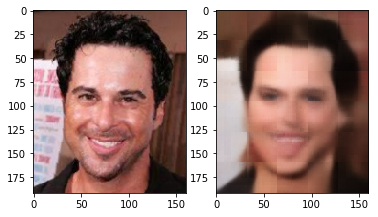

	Epoch 1 batch 4000 loss: 0.18992918729782104
	Epoch 1 batch 5000 loss: 0.19418394565582275


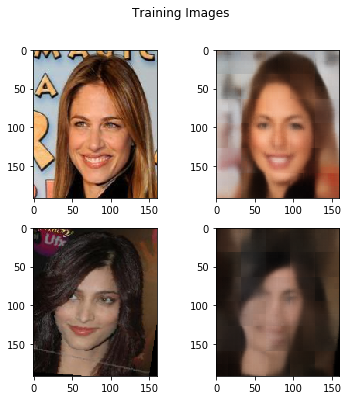

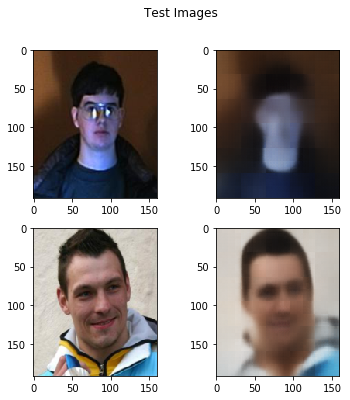

Epoch: 1 Train Loss: 992.6377397030592 Test Loss: 106.85753616690636
	Epoch 2 batch 1000 loss: 0.19922254979610443
	Epoch 2 batch 2000 loss: 0.18537014722824097
	Epoch 2 batch 3000 loss: 0.1889646202325821


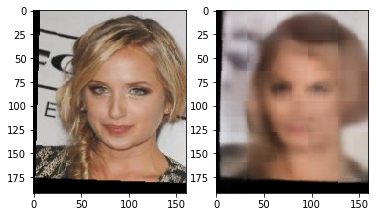

	Epoch 2 batch 4000 loss: 0.18537190556526184
	Epoch 2 batch 5000 loss: 0.20036235451698303


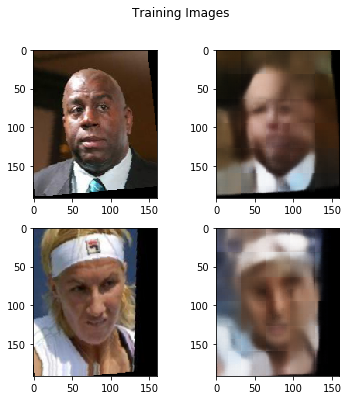

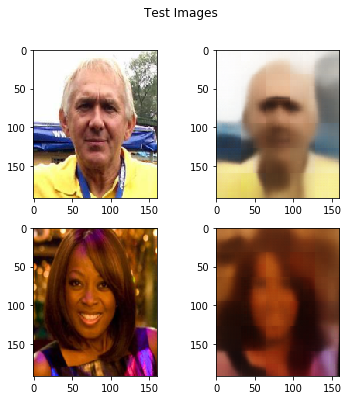

Epoch: 2 Train Loss: 940.9388407468796 Test Loss: 104.1103373169899
Copying file://gen_model_7_var.pt [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

|
Operation completed over 1 objects/326.9 MiB.                                    


In [0]:
# continue training entire model
train(generator, train_loader, g_optimizer, test_loader=test_loader, print_metrics=1000, plot_images=3000, num_epochs=2, display_images=1, scheduler=g_scheduler, save_path = "gen_model_7_var.pt")

	Epoch 0 batch 1000 loss: 0.09047406166791916
	Epoch 0 batch 2000 loss: 0.08232079446315765
	Epoch 0 batch 3000 loss: 0.09543243050575256


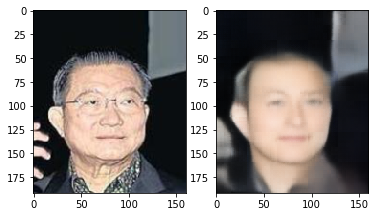

	Epoch 0 batch 4000 loss: 0.09774748980998993
	Epoch 0 batch 5000 loss: 0.09616011381149292
	Epoch 0 batch 6000 loss: 0.09731200337409973


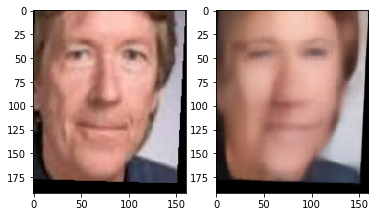

	Epoch 0 batch 7000 loss: 0.09029853343963623
	Epoch 0 batch 8000 loss: 0.09080947935581207
	Epoch 0 batch 9000 loss: 0.0856916755437851


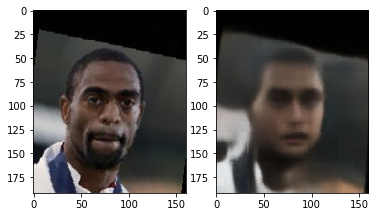

	Epoch 0 batch 10000 loss: 0.08993908017873764
	Epoch 0 batch 11000 loss: 0.09961502254009247
	Epoch 0 batch 12000 loss: 0.09278430044651031


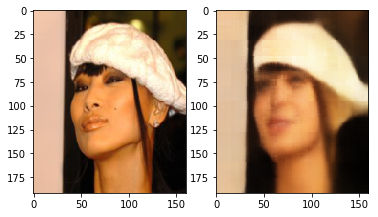

	Epoch 0 batch 13000 loss: 0.10304806381464005


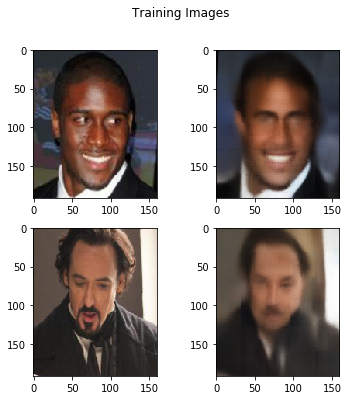

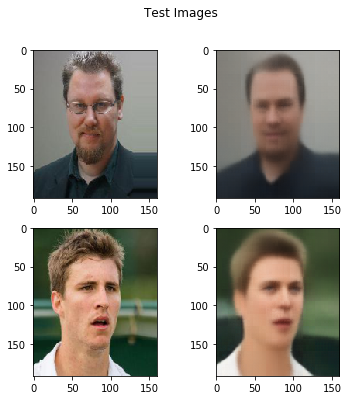

Epoch: 0 Train Loss: 1264.2714054435492 Test Loss: 52.45682564377785
	Epoch 1 batch 1000 loss: 0.09354531764984131
	Epoch 1 batch 2000 loss: 0.08916093409061432
	Epoch 1 batch 3000 loss: 0.0902506485581398


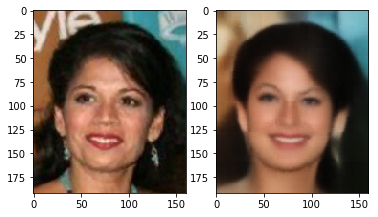

	Epoch 1 batch 4000 loss: 0.09298478066921234
	Epoch 1 batch 5000 loss: 0.09643444418907166
	Epoch 1 batch 6000 loss: 0.09116955101490021


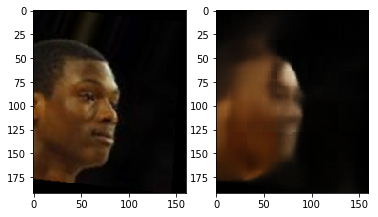

	Epoch 1 batch 7000 loss: 0.10350344330072403
	Epoch 1 batch 8000 loss: 0.09612155705690384
	Epoch 1 batch 9000 loss: 0.0936107188463211


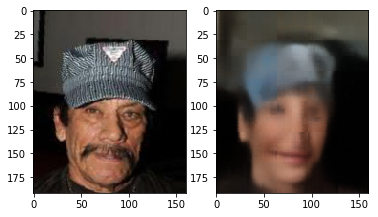

	Epoch 1 batch 10000 loss: 0.0986749678850174
	Epoch 1 batch 11000 loss: 0.08825352787971497
	Epoch 1 batch 12000 loss: 0.1043236255645752


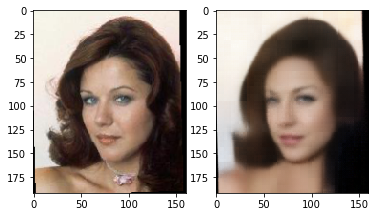

	Epoch 1 batch 13000 loss: 0.0938553512096405


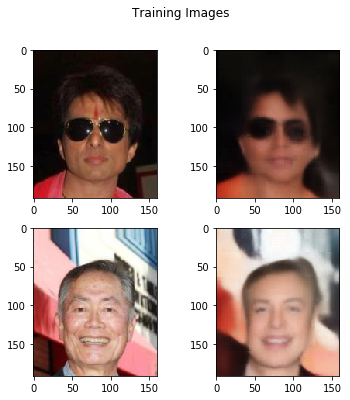

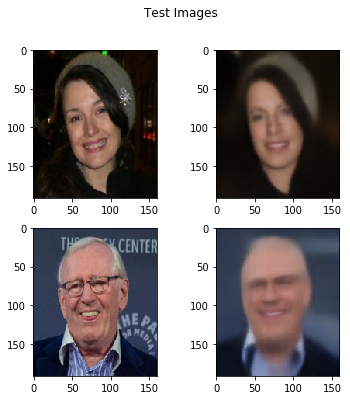

Epoch: 1 Train Loss: 1262.9228988066316 Test Loss: 51.80697723478079
Copying file://model_7.pt [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

\
Operation completed over 1 objects/326.9 MiB.                                    


In [0]:
# re-train encoder and decoder FC layers for 1 epochs
train(generator, train_loader, g_optimizer, test_loader=test_loader, print_metrics=1000, plot_images=3000, num_epochs=2, display_images=1, scheduler=g_scheduler, save_path = "model_7.pt")

	Epoch 1 batch 1000 loss: 0.08934591710567474
	Epoch 1 batch 2000 loss: 0.08562791347503662
	Epoch 1 batch 3000 loss: 0.0938190296292305


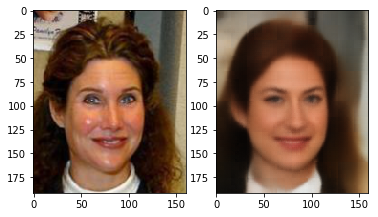

	Epoch 1 batch 4000 loss: 0.09299005568027496
	Epoch 1 batch 5000 loss: 0.09934471547603607
	Epoch 1 batch 6000 loss: 0.08787627518177032


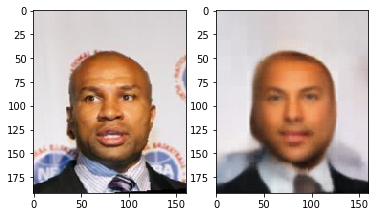

	Epoch 1 batch 7000 loss: 0.09727439284324646
	Epoch 1 batch 8000 loss: 0.08991573750972748
	Epoch 1 batch 9000 loss: 0.09790247678756714


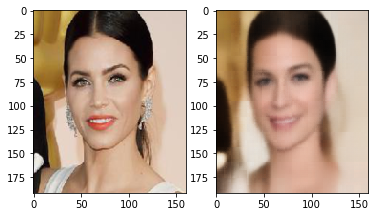

	Epoch 1 batch 10000 loss: 0.08669827878475189
	Epoch 1 batch 11000 loss: 0.090619757771492
	Epoch 1 batch 12000 loss: 0.0981188416481018


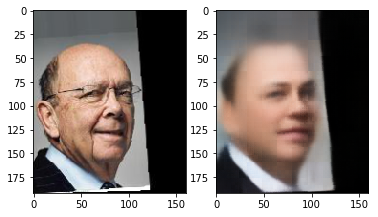

	Epoch 1 batch 13000 loss: 0.08673498779535294


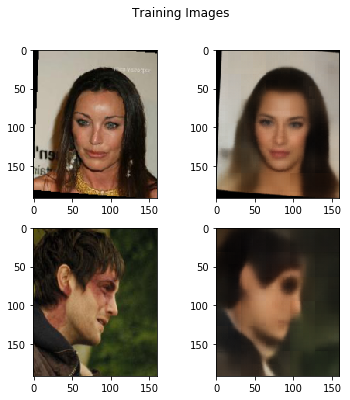

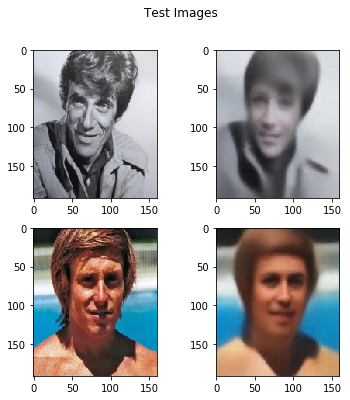

Epoch: 1 Train Loss: 1259.5642032548785 Test Loss: 51.84807822108269
	Epoch 2 batch 1000 loss: 0.0877206027507782
	Epoch 2 batch 2000 loss: 0.08702360093593597
	Epoch 2 batch 3000 loss: 0.08741072565317154


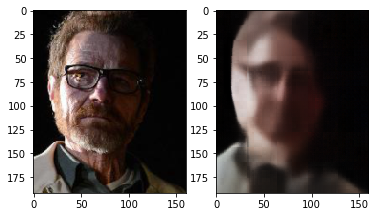

	Epoch 2 batch 4000 loss: 0.08448055386543274
	Epoch 2 batch 5000 loss: 0.09961949288845062
	Epoch 2 batch 6000 loss: 0.09597394615411758


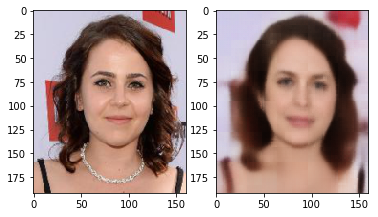

	Epoch 2 batch 7000 loss: 0.08934183418750763
	Epoch 2 batch 8000 loss: 0.09891737997531891
	Epoch 2 batch 9000 loss: 0.09416987001895905


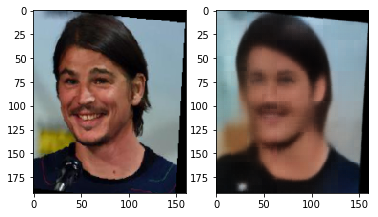

	Epoch 2 batch 10000 loss: 0.09258390218019485
	Epoch 2 batch 11000 loss: 0.09180198609828949
	Epoch 2 batch 12000 loss: 0.09793746471405029


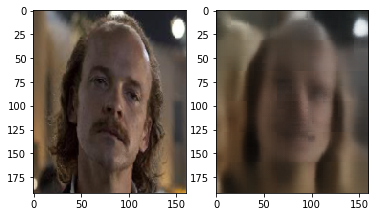

	Epoch 2 batch 13000 loss: 0.09350927174091339


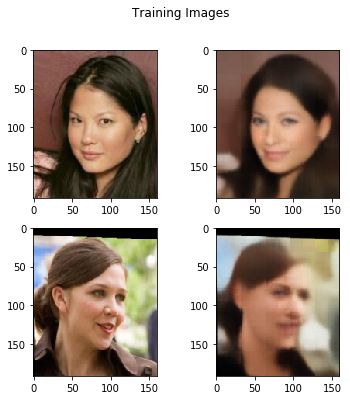

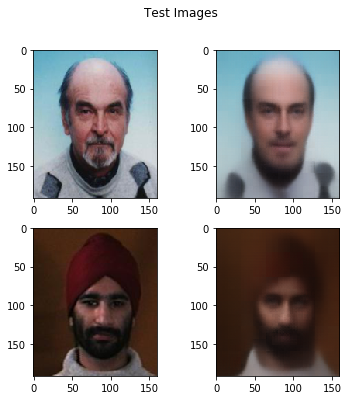

Epoch: 2 Train Loss: 1257.9027279540896 Test Loss: 52.057651668787
Copying file://model_7.pt [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

|
Operation completed over 1 objects/326.9 MiB.                                    


In [14]:
train(generator, train_loader, g_optimizer, test_loader=test_loader, print_metrics=2000, plot_images=4000, num_epochs=2, display_images=1, scheduler=g_scheduler, save_path = "model_7.pt")

	Epoch 0 batch 1000 loss: 0.09598389267921448
	Epoch 0 batch 2000 loss: 0.0841967761516571


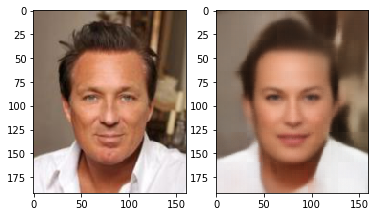

	Epoch 0 batch 3000 loss: 0.08989441394805908
	Epoch 0 batch 4000 loss: 0.08100492507219315


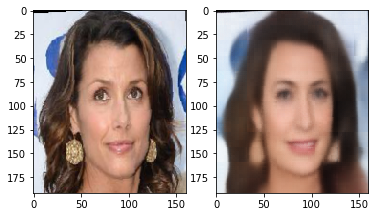

	Epoch 0 batch 5000 loss: 0.09702983498573303
	Epoch 0 batch 6000 loss: 0.08118216693401337


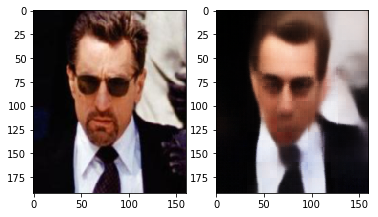

	Epoch 0 batch 7000 loss: 0.0968281477689743
	Epoch 0 batch 8000 loss: 0.09529509395360947


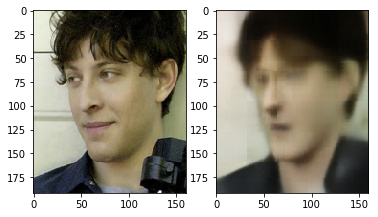

	Epoch 0 batch 9000 loss: 0.08981113880872726
	Epoch 0 batch 10000 loss: 0.08473743498325348


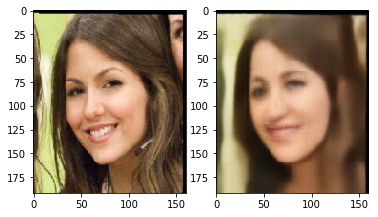

	Epoch 0 batch 11000 loss: 0.0818086564540863
	Epoch 0 batch 12000 loss: 0.08597956597805023


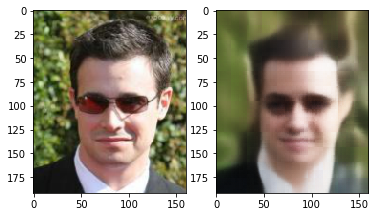

	Epoch 0 batch 13000 loss: 0.09314961731433868


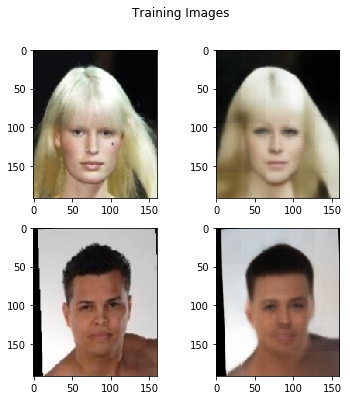

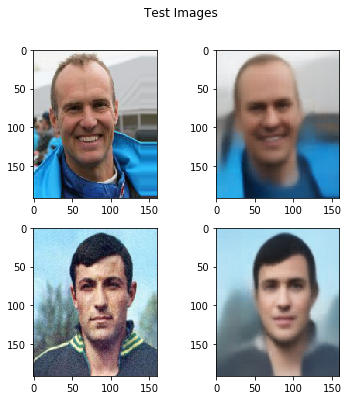

Epoch: 0 Train Loss: 1254.4588146731257 Test Loss: 51.64803399145603
	Epoch 1 batch 1000 loss: 0.09209582209587097
	Epoch 1 batch 2000 loss: 0.08042603731155396


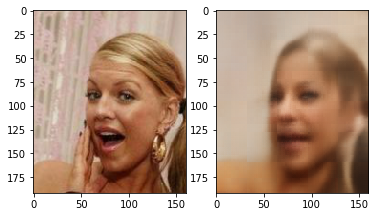

	Epoch 1 batch 3000 loss: 0.09374859184026718
	Epoch 1 batch 4000 loss: 0.08466176688671112


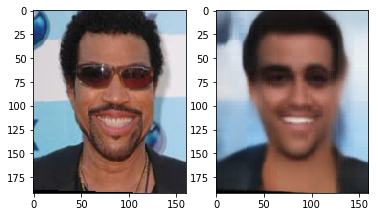

	Epoch 1 batch 5000 loss: 0.08440261334180832
	Epoch 1 batch 6000 loss: 0.08763860166072845


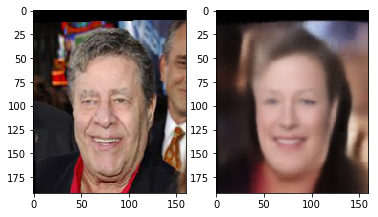

In [0]:
train(generator, train_loader, g_optimizer, test_loader=test_loader, print_metrics=1000, plot_images=2000, num_epochs=2, display_images=1, scheduler=g_scheduler, save_path = "model_7.pt")

In [0]:
## CHECK MEAN AND VARIANCE OF CODES
with torch.no_grad():
    for (inputs, _) in test_loader:
        generator.encoder.eval()
        generator.decoder.eval()
        # encode the images and reconstruct them
        codes, logvar = generator.encoder(inputs.cuda())
        recon = generator.decoder(codes)
        vae_loss(inputs.cuda(), recon, codes, logvar=logvar, debug = True)
        print("Code Mean:", torch.mean(codes))
        print("Code Std:", codes.std())
        print("Logvar Mean:", torch.mean(logvar))
        print("Logvar Std:", logvar.std())
        print("Logvar Exp:", logvar.exp())
        break

### Interpolation

In [0]:
## TRY SOME INTERPOLATION
with torch.no_grad():
    for (inputs, _) in train_loader:
      generator.encoder.eval()
      generator.decoder.eval()
      # encode the images and reconstruct them
      codes, _ = generator.encoder(inputs.cuda())
      recon = generator.decoder(codes)

      # plot the images against their reconstructions
      fig, ax = plt.subplots(2, 2, figsize=(6,6))
      fig.suptitle("Training Images")
      ax[0,0].imshow(inputs[0].cpu().permute(1, 2, 0) )
      ax[0,1].imshow(recon[0].cpu().detach().permute(1, 2, 0) )
      ax[1,0].imshow(inputs[1].cpu().permute(1, 2, 0) )
      ax[1,1].imshow(recon[1].cpu().detach().permute(1, 2, 0) )
      plt.show()
      
      # interpolate the codes
      int_code = (codes[0] + codes[1]) / 2

      # decode the interpolation
      int_recon = generator.decoder(int_code.reshape(1, 4096, 1, 1))

      # plot the reconstruction
      plt.imshow(int_recon[0].cpu().permute(1, 2, 0))
      plt.show()
      break

In [0]:
!mkdir data/Train
!cp -r data/images/Training_Pictures data/Train/Images

In [0]:
transform2 = torchvision.transforms.Compose(
    [torchvision.transforms.Resize((192,160)),
      torchvision.transforms.ToTensor(),
    ])

train_dataset2 = torchvision.datasets.ImageFolder(
        root="data/Train",
        transform=transform
    )

train_loader2 = torch.utils.data.DataLoader(
    train_dataset2,
    batch_size=14,
    num_workers=2,
    shuffle=True
)

In [0]:
train(generator, train_loader2, g_optimizer, test_loader=test_loader, print_metrics=1000, plot_images=1, num_epochs=25, display_images=1, scheduler=g_scheduler, save_path = "model_7.pt")

In [0]:
with torch.no_grad():
    for (inputs, _) in train_loader2:
      for i, image in enumerate(inputs):
        plt.imshow(image.cpu().permute(1, 2, 0))
        plt.title(str(i))
        plt.show()
      break

In [0]:
with torch.no_grad():
    for (inputs, _) in train_loader2:
      for i, image in enumerate(inputs):
        generator.encoder.eval()                                
        generator.decoder.eval()
        # encode the images and reconstruct them
        codes, _ = generator.encoder(inputs.cuda())
        recon = generator.decoder(codes)

        # plot the images against their reconstructions
        fig, ax = plt.subplots(2, 2, figsize=(6,6))
        ax[0,0].imshow(inputs[23].cpu().permute(1, 2, 0) )
        ax[0,1].imshow(recon[23].cpu().detach().permute(1, 2, 0) )
        ax[1,0].imshow(inputs[5].cpu().permute(1, 2, 0) )
        ax[1,1].imshow(recon[5].cpu().detach().permute(1, 2, 0) )
        plt.show()

        # interpolate the codes
        int_code = (codes[1] + codes[5]) / 2

          # decode the interpolation
        int_recon = generator.decoder(int_code.reshape(1, 4096, 1, 1))

        # plot the reconstruction
        plt.imshow(int_recon[0].cpu().permute(1, 2, 0))
        plt.show()
        break
      break

In [0]:
with torch.no_grad():
    for (inputs, _) in train_loader2:
      generator.encoder.eval()
      generator.decoder.eval()
      # encode the images and reconstruct them
      codes, _ = generator.encoder(inputs.cuda())
      recon = generator.decoder(codes)

      # plot the images against their reconstructions
      fig, ax = plt.subplots(2, 2, figsize=(6,6))
      ax[0,0].imshow(inputs[4].cpu().permute(1, 2, 0) )
      ax[0,1].imshow(recon[5].cpu().detach().permute(1, 2, 0) )
      ax[1,0].imshow(inputs[4].cpu().permute(1, 2, 0) )
      ax[1,1].imshow(recon[5].cpu().detach().permute(1, 2, 0) )
      plt.show()

      # interpolate the codes
      int_code = (codes[4] + codes[5]) / 2

        # decode the interpolation
      int_recon = generator.decoder(int_code.reshape(1, 4096, 1, 1))

      # plot the reconstruction
      plt.imshow(int_recon[0].cpu().permute(1, 2, 0))
      plt.show()
      break
     

In [0]:
with torch.no_grad():
    for (inputs, _) in train_loader2:
      for i, image in enumerate(inputs):
        generator.encoder.eval()
        generator.decoder.eval()
        # encode the images and reconstruct them
        codes, _ = generator.encoder(inputs.cuda())
        recon = generator.decoder(codes)

        # plot the images against their reconstructions
        fig, ax = plt.subplots(2, 2, figsize=(6,6))
        ax[0,0].imshow(inputs[18].cpu().permute(1, 2, 0) )
        ax[0,1].imshow(recon[18].cpu().detach().permute(1, 2, 0) )
        ax[1,0].imshow(inputs[19].cpu().permute(1, 2, 0) )
        ax[1,1].imshow(recon[19].cpu().detach().permute(1, 2, 0) )
        plt.show()

        # interpolate the codes
        int_code = (codes[18] + codes[19]) / 2

          # decode the interpolation
        int_recon = generator.decoder(int_code.reshape(1, 4096, 1, 1))

        # plot the reconstruction
        plt.imshow(int_recon[0].cpu().permute(1, 2, 0))
        plt.show()
        break
      break

In [0]:
train(generator, train_loader=train_loader2, optimizer=optimizer, print_metrics=10, plot_images=1, num_epochs=25, display_images=1, scheduler=scheduler)

In [0]:
train(model, train_loader=train_loader2, optimizer=optimizer, print_metrics=10, plot_images=1, num_epochs=30, display_images=1, scheduler=scheduler)

In [0]:
noise = np.random.normal(loc=0.3, scale=7.5, size=4096).reshape((1,4096,1,1))
image = model.decoder(torch.from_numpy(noise).cuda().float())
plt.imshow(image[0].cpu().detach().permute(1,2,0))
plt.show()